**INPUT -- WHOLE AND SCAFFOLD SMILES**

- input entry (visualizing both)
- Identify the attachment points
- Display the scaffold with the indexes and ask user entry for the preferred regions of attachment and growth

In [10]:
import importlib
import itertools
import utils
from utils import *
importlib.reload(codes)
import warnings
warnings.filterwarnings('ignore')

**Loading relevant Data and Files**

- whole_smiles = Smile of the full parent molecule
- scaffold =  Smile of the scaffold of interest from the parent molecule
- fragment_df = Dataframe containing fragment smiles with the attachment points. They smiles should be stored under a column with name **Fragments**

In [11]:
whole_smiles = "[2H]C([2H])([2H])NC(=O)C1=NN=C(C=C1NC2=CC=CC(=C2OC)C3=NN(C=N3)C)NC(=O)C4CC4"
scaffold_smiles ="COC1=CC=CC=C1N"
fragment_df = pd.read_csv("LC_lead_like_fragments.csv")


**Visualization of the Whole molecule and the scaffold**

(-0.5, 299.5, 299.5, -0.5)

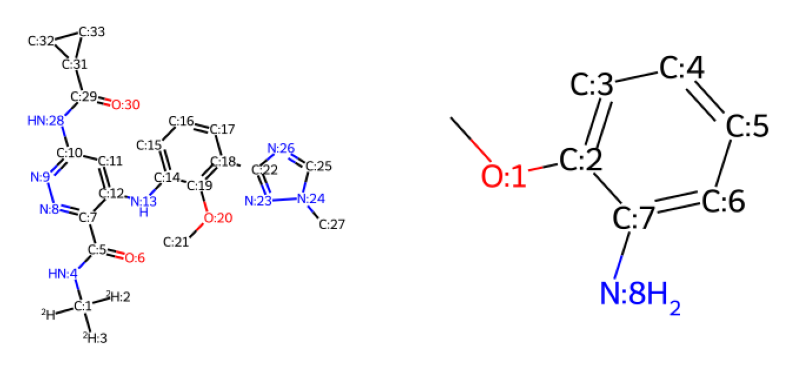

In [12]:
whole_mol = Chem.MolFromSmiles(whole_smiles)
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles)

fig , ax = plt.subplots(1, 2, figsize = (10,5))

whole_mol_img = Draw.MolToImage(codes.mol_idx_image(whole_mol))
ax[0].imshow(whole_mol_img)
ax[0].axis('off')
scaffold_mol_img = Draw.MolToImage(mol_idx_image(scaffold_mol))
ax[1].imshow(scaffold_mol_img)
ax[1].axis('off')

**Selection of Attachment points**

 The attachment points that will be reccomended will be the same points where fragments where attached in the parent molecule. The user can choose any number of the reccomended attachment points.

- selected atts: Stores the indexes of the attachment points in a list
- frag_repl: Stores the attachment points and the replaced fragment smiles as a dictionary

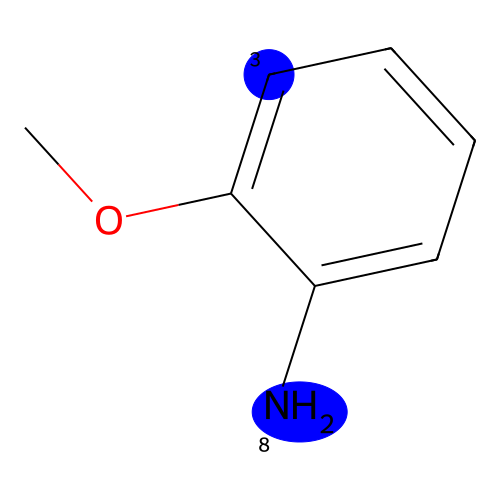

Selected Attachment points: [3, 8]
The fragments attached to the chosen attachment points: {8: '[2H][C:1]([2H:2])([2H:3])[NH:4][C:5](=[O:6])[c:7]1[n:8][n:9][c:10]([NH:28][C:29](=[O:30])[CH:31]2[CH2:32][CH2:33]2)[cH:11][cH:12]1', 3: '[cH:22]1[n:23][n:24]([CH3:27])[cH:25][n:26]1'}


In [13]:
result = find_attachment_points(whole_mol, scaffold_mol, scaffold_smiles)
selected_atts = result['selected_attachments']
frag_repl = result["frag_repl"]

print("Selected Attachment points:",result["selected_attachments"])
print("The fragments attached to the chosen attachment points:",result["frag_repl"])


**Specify Molecule Count for Generation**

The total number of possible molecules is determined by the number of attachment points and the number of fragments available in fragment_df.

- cutoff: A threshold value calculated to determine how many fragments from fragment_df should be selected in order to generate the specified number of molecules.

In [14]:

fragment_df = fragment_df.drop_duplicates(subset="Fragments")
fragment_df = fragment_df.dropna(subset='Fragments')
fragment_df = fragment_df[fragment_df['Fragments'].str.contains(r"\[[^\]]*\*[^\]]*\]", regex=True, na=False)]


total, revised, cutoff = calculate_cutoff(fragment_df, selected_atts)




Total possible molecules: 5764801


No. of molecules to generate: 1000


**Descriptor Calculation and Similarity Filteration**

The code calculates the following molecular descriptors:
- MolWt (Molecular Weight)
- LogP (Partition Coefficient)
- TPSA (Topological Polar Surface Area)
- HBA (Hydrogen Bond Acceptors)
- HBD (Hydrogen Bond Donors)
- Rotatable Bonds

Fragments are then screened based on their similarity to the replaced fragments and the calculated cutoff value.

In [15]:
fragment_desc = process_fragments(fragment_df, calc_props)
fragment_desc.to_csv("Fragments_desc.csv",index=False)
similar_dfs = process_and_save_similar_fragments(frag_repl, fragment_desc, cutoff)

**Fragment Attachment and Dataframe Generation**

Molecules are saved as Smiles under a column named the same

In [7]:
index_dict = {}

for k, v in similar_dfs.items():
    similar_dfs[k] = prepare_fragments(v)
    index_dict[k] = similar_dfs[k].index.to_list()

combinations = list(itertools.product(*index_dict.values()))

final_mol_df = generate_final_molecules(combinations, scaffold_mol, similar_dfs, att_to_C_conversion)
final_mol_df.head()

,Smiles
0,COc1c(Cn2nnc3c(C)ncnc32)cccc1NCC(=O)C1=C(C)Nc2...
1,COc1c(Cc2ncnc3c2nnn3C)cccc1NCC(=O)C1=C(C)Nc2nc...
2,COc1c(CC2CCc3ccccc3O2)cccc1NCC(=O)C1=C(C)Nc2nc...
3,COc1c(CS(=O)(=O)c2ccc(F)cc2C)cccc1NCC(=O)C1=C(...
4,COc1c(Cn2nc(C)cc2C)cccc1NCC(=O)C1=C(C)Nc2ncnn2...


In [8]:
final_mol_df.to_csv("generated_mols.csv")